# Notebook to test SetFit performance

# Setup and data cleaning

## Check if CUDA is available and use it if it is

In [ ]:
import torch
import json
from datetime import datetime
import os
from sentence_transformers.losses import CosineSimilarityLoss, BatchAllTripletLoss, BatchHardTripletLossDistanceFunction
from transformers import PrinterCallback, ProgressCallback
from setfit import Trainer, TrainingArguments, sample_dataset, SetFitModel
import gc
import time
import pandas as pd
import numpy as np

import logging
import warnings

# Disable some logs because there were too many messages during the tests
logging.disable(logging.INFO)
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

from datasets import Dataset, disable_progress_bar
disable_progress_bar() # Disable the "Map" progress bar during the tests

if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Load and clean the dataset

This dataset is not on the GitHub repository.
It's composed of work experienced fetched from LinkedIn and labelled between 0 and 4 (0 if it's not related to AI and 4 if it is)

In [ ]:
dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset = subset[['text','label']]
subset_label_transform = subset.copy()

subset_label_transform['label'] = np.where((subset_label_transform["label"] < 3) | (subset_label_transform["label"].isna()), 0, 1)
subset_label_transform

## Split the dataset in two subsets : the training and test sets

In [ ]:
# Here we don't use sklearn's function since we just want to split the dataset and we are not separating labels and descriptive variables

def split_dataset(dataset, ratio):
    """Split a dataset in two parts

    Args:
        dataset (pandas.DataFrame)
        ratio (integer): Ratio of the size of the first subset compared to the whole dataset

    Returns:
        (pandas.DataFrame): First subset (size = dataset size * ratio)
        (pandas.DataFrame): Second subset (size = dataset size * (1-ratio))
    """
    first_set = dataset.sample(frac = ratio, random_state=42)
    second_set = dataset.drop(first_set.index)
    return first_set, second_set

train_set, test_set = split_dataset(subset_label_transform, 0.2)

## Repeat this process with diffent ways of cleaning the data

Here instead of considering Nan, 0, 1 and 2 as not being an AI experience and 3 and 4 as being one, we consider :

- not AI = 0 and 1 and AI = 3 and 4 (we drop the examples with the label NaN or 2)
- not AI = 0 and AI = 4 (we drop the examples with the label NaN, 1, 2 or 3)

In [ ]:
subset_label_transform_likely_labels = subset.copy()
subset_label_transform_likely_labels.replace({2: np.nan}, inplace=True)
subset_label_transform_likely_labels.dropna(inplace=True)
subset_label_transform_likely_labels['label'] = np.where((subset_label_transform_likely_labels["label"] < 3), 0, 1)

subset_label_transform_sure_labels = subset.copy()
subset_label_transform_sure_labels.replace({1: np.nan, 2: np.nan, 3: np.nan}, inplace=True)
subset_label_transform_sure_labels.dropna(inplace=True)
subset_label_transform_sure_labels['label'] = np.where((subset_label_transform_sure_labels["label"] == 0), 0, 1)

# We keep the full test set
train_set_likely_labels, _ = split_dataset(subset_label_transform_likely_labels, 0.2) 
train_set_sure_labels, _ = split_dataset(subset_label_transform_sure_labels, 0.2)

# Functions to test different hyper parameters

In this section we define all the functions used for the different tests

## Estimate remaining time

In [ ]:
def get_remaining_time_str(start_time, progress, progress_end):
    """Get the remaining time as a string (in seconds if < 60 s otherwise in minutes, e.g: 67 m)

    Args:
        start_time (float): Time when the first iteration has started
        progress (int): Current iteration (start at 1)
        progress_end (int): Number of iterations

    Returns:
        string: String representing the estimated remaining time in minutes (if at least 60 s) or in seconds
    """
    elapsed_time = time.time() - start_time
    if progress <= 1:
        return "?"
    
    time_per_iter = elapsed_time / progress
    remaining_seconds = (time_per_iter * (1 + progress_end - progress))
    if remaining_seconds < 60:
        return str(round(remaining_seconds)) + " s"
    else:
        return str(round(remaining_seconds/60)) + " m"
    

## Save test data to a file

The filename of the save files are the current time, e.g. 2024-03-14_13-58-01

In [ ]:
def save_to_json(results, run_times, params, folder_path):
    """Save test data in the given folder

    Args:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
        params (dict): Parameters used for the test (N-shots, number of iterations, ...)
        folder_path (string): Path were the test file will be saved
    """
    
    if "loss" in params:
        if type(params["loss"]) == type({}):
            list_losses = []
            for key in params["loss"].keys():
                list_losses.append(key)
            params["loss"] = list_losses
        else:
            if params["loss"] == CosineSimilarityLoss:
                params["loss"] = "Pair-wise"
            elif params["loss"] == BatchAllTripletLoss:
                params["loss"] = "Triplet"
            else:
                params["loss"] = "UNKNOWN"

    if "distance" in params:
        list_distances = []
        for key in params["distance"].keys():
            list_distances.append(key)
            params["distance"] = list_distances

    if "num_epochs" in params:
        if type(params["num_epochs"]) == type([]):
            for i in range(len(params["num_epochs"])):
                params["num_epochs"][i] = f"({params['num_epochs'][i][0]},{params['num_epochs'][i][1]})"
        else:
            params["num_epochs"] = f"({params['num_epochs'][0]},{params['num_epochs'][1]})"

    object = {"results":results, "run_times":run_times, "params": params}

    # Create folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Generate file name
    date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_name = folder_path+'/'+str(date)+".json"

    # Create file and save data
    with open(file_name, 'w') as file:
        json.dump(object, file)

## Training the model with given parameters

In [ ]:
def get_transformer_model(model_name, use_differentiable_head=False):
    """Get the transformer model from the HuggingFace hub from its name (and download it if it's not on the current machine)

    Args:
        model_name (string): Name of the transformer to be fetched
        use_differentiable_head (bool, optional): False if we want to use the default Logistic classification head and false if we want to use the PyTorch's one (needed for multiclass classification). Defaults to False.

    Returns:
        SetFitModel : SetFit model created with the given transformer
    """
    model = SetFitModel.from_pretrained(model_name, use_differentiable_head=use_differentiable_head)
    gc.collect()
    torch.cuda.empty_cache()
    
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset, distance_metric = BatchHardTripletLossDistanceFunction.cosine_distance, num_epochs = (1,16), batch_size = (16,2), head_learning_rate = 1e-2):
    """Initialize the trainer with the test params

    Args:
        model (SetFitModel): SetFit model that will be train with this new trainer
        loss (object): Loss function used (e.g. CosineSimilarityLoss)
        train_dataset (datasets.Dataset): Training set
        test_dataset (datasets.Dataset): Test set
        distance_metric (object, optional): Distance used to compare a pair/triplet of embeddings. Defaults to BatchHardTripletLossDistanceFunction.cosine_distance.
        num_epochs (tuple, optional): Number of epochs: (body_num_epochs, head_num_epochs). Defaults to (1,16).
        batch_size (tuple, optional): Size of the batches: (body_batch_size, head_batch_size). Defaults to (16,2).
        head_learning_rate (number, optional): Head learning rate. Defaults to 1e-2.
    """
    
    trainer_arguments = TrainingArguments(
        show_progress_bar=False,
        loss=loss,
        distance_metric=distance_metric,
        batch_size=batch_size,
        num_epochs=num_epochs,
		head_learning_rate=head_learning_rate,
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    
    # Disable some logs because there were too many messages during the tests
    trainer.pop_callback(PrinterCallback)
    trainer.pop_callback(ProgressCallback)
    
    return trainer

def setfit_f1_score(train_set, test_set, model_name, loss, distance_metric = None, num_epochs = None , batch_size = None, head_learning_rate = None):
    """Initialize and test a SetFit model with the given params

    Args:
        train_dataset (datasets.Dataset): Training set
        test_dataset (datasets.Dataset): Test set
        model_name (string): Name of the transformer to be fetched
        loss (object): Loss function used (e.g. CosineSimilarityLoss)
        distance_metric (object, optional): Distance used to compare a pair/triplet of embeddings. Defaults to None.
        num_epochs (tuple, optional): Number of epochs: (body_num_epochs, head_num_epochs). Defaults to None.
        batch_size (tuple, optional): Size of the batches: (body_batch_size, head_batch_size). Defaults to None.
        head_learning_rate (number, optional): Head learning rate. Defaults to None.

    Raises:
        Exception: If the training set or test set contain only one example, since at least are required by SetFit to create sentence pairs

    Returns:
        number: F1-score
        number: Run time (training only)
    """
    
    if len(train_set) <= 1 or len(test_set) <= 1:
        raise Exception
    
    # Replace by None with default values
    if distance_metric is None:
        distance_metric = BatchHardTripletLossDistanceFunction.cosine_distance
    if num_epochs is None:
        num_epochs = (1,16)
    if batch_size is None:
        batch_size = (16,2)
    if head_learning_rate is None:
        head_learning_rate = 1e-2
    
    model = get_transformer_model(model_name, (not (num_epochs is None)) and num_epochs[1]>1)

    trainer = init_trainer(model, loss, train_set, test_set, distance_metric, num_epochs, batch_size, head_learning_rate)
    
    start_time = time.time()
    trainer.train()
    run_time = time.time() - start_time
    
    metrics = trainer.evaluate()
    
    del model
    del trainer
    torch.cuda.empty_cache()
    
    return metrics['f1'], run_time

import protoNet

def protonet_f1_score(train_set, test_set, model_name=None, loss=None, distance_metric = None, num_epochs = None , batch_size = None, head_learning_rate = None):
    tokenizer, model = protoNet.get_tokenizer_and_model()
    support_set = protoNet.gen_support_set(len(train_set)//2, tokenizer, train_set)
    
    start_time = time.time()
    model = protoNet.protonet_train(support_set, train_set, tokenizer, model)
    run_time = time.time() - start_time

    print("Eval...")
    f1_score = protoNet.eval(test_set, tokenizer, model, support_set)
    
    del model
    torch.cuda.empty_cache()
    
    return f1_score, run_time


## Apply filters to the dataset

In [ ]:
from langdetect import detect

def filter_lang(data, lang):
    """Only keep the rows in which the text column is in the given language

    Args:
        data (datasets.Dataset): Data to be filtered
        lang (string): Language used to filter the data (e.g. 'fr' or 'en')

    Returns:
        datasets.Dataset: Filtered data
    """
    indices = []
    for i in range(len(data)):
        try:
            l = detect(data.iloc[i]["text"])
            if l == lang:
                indices.append(i)
        except:""
    
    return data.iloc[indices]

def filter_dataset(data, min_text_length=None, max_text_length=None, lang=None):
    """Filter a dataset on language and length (in number of words) filters

    Args:
        data (datasets.Dataset): Dataset to be filtered
        min_text_length (int, optional): Min length of the string in the text field. If the length is lesser than it then the row is dropped. If it's None there is no filter. Defaults to None.
        max_text_length (int, optional): Max length of the string in the text field. If the length is greater than it then the row is dropped. If it's None there is no filter. Defaults to None.
        lang (string, optional): Language used to filter the data (e.g. 'fr' or 'en'). If it's None there is no filter. Defaults to None.

    Returns:
        datasets.Dataset: Filtered dataset
    """
    if min_text_length is None:
        if max_text_length is None:
            filtered_data = data
        else:
            filtered_data = data[data['text'].str.split().apply(len) <= max_text_length]
    else:
        if max_text_length is None:
            filtered_data = data[data['text'].str.split().apply(len) >= min_text_length]
        else:
            filtered_data = data[data['text'].str.split().apply(len).between(min_text_length, max_text_length)]
            
    if not (lang is None):
        filtered_data = filter_lang(filtered_data, lang)
           
    return filtered_data

### N-Shots

In [ ]:
def n_shot_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit N-shots test

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    
    n_values = params["n_shot"]
    n_iter = params["n_iter"]
    n_max_iter_per_shot = params["n_max_iter_per_shot"]
    model = params["model"]
    loss = params["loss"]
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None
    
    n_values_max = np.max(n_values)

    results = {}
    run_times = {}
    for n_shot in n_values:
        results[n_shot] = []
        run_times[n_shot] = []
    
    progress = 0
    progress_end = n_iter * ((len(n_values)-1)*n_max_iter_per_shot + 1)
    
    start_time = time.time()
    # Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
    for i in range(n_iter):
        # Use the same subset of the dataset for all of the tests in the following loop
        if not (input_length_range is None):
            new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
        else:
            new_train_set = train_set
        new_train_set = new_train_set.sample(frac = 1, random_state=i*47).groupby('label').head(n_values_max)
        new_train_set = Dataset.from_pandas(new_train_set, split="train")
        new_test_set = Dataset.from_pandas(test_set, split="test")

        for n_shot in n_values:
            # try:
            n_iter_shot = n_max_iter_per_shot if n_shot < n_values_max else 1
            for i_shot in range(n_iter_shot):
                progress += 1
                print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
    
                train_set_n_shot = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*n_shot + 3*i_shot)
                f1_score, run_time = few_shot_model_f1_function(train_set_n_shot, new_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
                results[n_shot].append(f1_score)
                run_times[n_shot].append(run_time)
            # except Exception as err:
            #     print(n_shot, "failed", str(err))
    return results, run_times

### Input length

In [ ]:
def input_length_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit input length test

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    
    n_shot = params["n_shot"]
    len_values = params["input_length_range"]
    n_iter = params["n_iter"]
    model = params["model"]
    loss = params["loss"]
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None
    
    results = {}
    run_times = {}
    new_test_set = Dataset.from_pandas(test_set, split="test")

    for i in range(len(len_values)):
        key = f"[{len_values[i][0]},{len_values[i][1]}]"
        results[key] = []
        run_times[key] = []

    progress = 0
    progress_end = n_iter * len(len_values)
    start_time = time.time()
    
    # Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
    for iter in range(n_iter):
        for i in range(len(len_values)):
            key = f"[{len_values[i][0]},{len_values[i][1]}]"
            try:
                progress += 1
                print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
    
                new_train_set = filter_dataset(train_set, len_values[i][0], len_values[i][1])
                new_train_set = Dataset.from_pandas(new_train_set, split="train")
                new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
                f1_score, run_time = few_shot_model_f1_function(new_train_set, new_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
                results[key].append(f1_score)
                run_times[key].append(run_time)
            except Exception as err:
                print(key, "failed", str(err))
    return results, run_times

### Distance

In [ ]:
def distance_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit distance test

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    
    n_shot = params["n_shot"]
    n_iter = params["n_iter"]
    model = params["model"]
    loss = params["loss"]
    distances = params["distance"]
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None

    results = {}
    run_times = {}
    for key in distances.keys():
        results[key] = []
        run_times[key] = []

    new_test_set = Dataset.from_pandas(test_set, split="test")
 
    progress = 0
    progress_end = n_iter * (len(distances))
    start_time = time.time()
    
    for i in range(n_iter):
        if not (input_length_range is None):
            new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
        else:
            new_train_set = train_set
        new_train_set = Dataset.from_pandas(new_train_set, split="train")
        new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)
        
        for key in distances.keys():
            progress += 1
            print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
   
            try:
                f1_score, run_time = few_shot_model_f1_function(new_train_set, new_test_set, model, loss, distances[key], num_epochs=num_epochs, batch_size=batch_size)
                results[key].append(f1_score)
                run_times[key].append(run_time)
            except Exception as err:
                print(key, "failed", str(err))
    return results, run_times

### Loss

In [ ]:
def loss_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit loss test

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    n_shot = params["n_shot"]
    n_iter = params["n_iter"]
    model = params["model"]
    losses = params["loss"]
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None
 
    results = {}
    run_times = {}
    for key in losses.keys():
        results[key] = []
        run_times[key] = []

    new_test_set = Dataset.from_pandas(test_set, split="test")
 
    progress = 0
    progress_end = n_iter * (len(losses))
    start_time = time.time()
    
    for i in range(n_iter):
        if not (input_length_range is None):
            new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
        else:
            new_train_set = train_set
        new_train_set = Dataset.from_pandas(new_train_set, split="train")
        new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)
        
        for key in losses.keys():
            progress += 1
            print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
   
            try:
                f1_score, run_time = few_shot_model_f1_function(new_train_set, new_test_set, model, losses[key], num_epochs=num_epochs, batch_size=batch_size)
                results[key].append(f1_score)
                run_times[key].append(run_time)
            except Exception as err:
                print(key, "failed", str(err))
    return results, run_times

### Language

In [ ]:
def language_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit language test

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    
    n_shot = params["n_shot"]
    n_iter = params["n_iter"]
    model = params["model"]
    loss = params["loss"]
    languages = params["lang"]
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None
 
    results = {}
    run_times = {}

    for key in languages:
        results[key] = []
        run_times[key] = []
    results['all'] = []
    run_times['all'] = []
 
    progress = 0
    progress_end = n_iter * (len(languages) + 1)
    start_time = time.time()
    
    for i in range(n_iter):
        temp_train_set_panda = {}
        temp_test_set_panda = {}

        for key in languages:
            progress += 1
            print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
   
            temp_train_set_panda[key] = filter_dataset(train_set, lang=key)
            if not (input_length_range is None):
                temp_train_set_panda[key] = filter_dataset(temp_train_set_panda[key], input_length_range[0], input_length_range[1])
            temp_train_set = Dataset.from_pandas(temp_train_set_panda[key], split="train")
            temp_train_set = sample_dataset(temp_train_set, label_column="label", num_samples=n_shot, seed=47*i)
   
            temp_test_set_panda[key] = filter_dataset(test_set, lang=key)
            temp_test_set = Dataset.from_pandas(temp_test_set_panda[key], split="test")
            try:
                f1_score, run_time = few_shot_model_f1_function(temp_train_set, temp_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
                results[key].append(f1_score)
                run_times[key].append(run_time)
            except Exception as err:
                print(key, "failed", str(err))
                del temp_train_set_panda[key]
                del temp_test_set_panda[key]
        
        all_temp_train_set = list(temp_train_set_panda.values())
        all_temp_test_set = list(temp_train_set_panda.values())
  
        if len(all_temp_train_set) == 0 or len(all_temp_test_set) == 0:
            progress += 1
            print("Step:", progress, "/", progress_end, "failed")
            continue

        progress += 1
        print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
        
        try:
            all_train_set = pd.concat(all_temp_train_set)
            all_train_set = Dataset.from_pandas(all_train_set, split="test")
            all_train_set = sample_dataset(all_train_set, label_column="label", num_samples=n_shot, seed=47*i)
            all_test_set = pd.concat(all_temp_test_set)
            all_test_set = Dataset.from_pandas(all_test_set, split="test")
  
            f1_score, run_time = few_shot_model_f1_function(all_train_set, all_test_set, model, loss)
            results['all'].append(f1_score)
            run_times['all'].append(run_time)
        except Exception as err:
            print('all', "failed", str(err))
    return results, run_times

### Sentence transformers

Test SetFit with different ST models

In [ ]:
def model_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit model test

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    
    n_shot = params["n_shot"]
    n_iter = params["n_iter"]
    loss = params["loss"]
    models = params["model"]
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None
 
    results = {}
    run_times = {}
    new_test_set = Dataset.from_pandas(test_set, split="test")
    start_time = time.time()

    for key in models.keys():
        results[key] = []
        run_times[key] = []

    progress = 0
    progress_end = n_iter * len(models)
 
    for i in range(n_iter):
        # Use the same subset of the dataset for all of the tests in the following loop
        if not (input_length_range is None):
            new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
        else:
            new_train_set = train_set
        new_train_set = Dataset.from_pandas(new_train_set, split="train")
        new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

        for key, full_model_name in models.items():
            progress += 1
            print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
   
            try:
                f1_score, run_time = few_shot_model_f1_function(new_train_set, new_test_set, full_model_name, loss, num_epochs=num_epochs, batch_size=batch_size)
                results[key].append(f1_score)
                run_times[key].append(run_time)
            except Exception as err:
                print(key, "failed", str(err))
    return results, run_times

### Number of epochs

In [ ]:
def num_epochs_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit test on the number of epochs

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    n_shot = params["n_shot"]
    n_iter = params["n_iter"]
    loss = params["loss"]
    model = params["model"]
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
    num_epochs = params["num_epochs"]
    batch_size = params["batch_size"] if "batch_size" in params else None
 
    results = {}
    run_times = {}
    new_test_set = Dataset.from_pandas(test_set, split="test")

    for epoch_tuple in num_epochs:
        key = f"({epoch_tuple[0]}, {epoch_tuple[1]})"
        results[key] = []
        run_times[key] = []

    progress = 0
    progress_end = n_iter * len(num_epochs)
    start_time = time.time()
    
    for i in range(n_iter):
        # Use the same subset of the dataset for all of the tests in the following loop
        if not (input_length_range is None):
            new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
        else:
            new_train_set = train_set
        new_train_set = Dataset.from_pandas(new_train_set, split="train")
        new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

        for epoch_tuple in num_epochs:
            key = f"({epoch_tuple[0]}, {epoch_tuple[1]})"
            progress += 1
            print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
   
            try:
                f1_score, run_time = few_shot_model_f1_function(new_train_set, new_test_set, model, loss, num_epochs=epoch_tuple, batch_size=batch_size)
                results[key].append(f1_score)
                run_times[key].append(run_time)
            except Exception as err:
                print(key, "failed", str(err))
    return results, run_times

### Data sampling

In [ ]:
def constant_params_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit test with constant parameters (but we still iterate multiple times to test with different training sets)

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    n_shot = params["n_shot"]
    n_iter = params["n_iter"]
    loss = params["loss"]
    model = params["model"]
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
 
    results = []
    run_times = []
    new_test_set = Dataset.from_pandas(test_set, split="test")
    progress = 0

    for i in range(n_iter):
        progress += 1
        print("Step:", progress, "/", n_iter)
        if not (input_length_range is None):
            new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
        else:
            new_train_set = train_set
        new_train_set = Dataset.from_pandas(new_train_set, split="train")
        new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

        try:
            f1_score, run_time = few_shot_model_f1_function(new_train_set, new_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
            results.append(f1_score)
            run_times.append(run_time)
        except Exception as err:
                print(i, "failed", str(err))
    return {"all":results}, {"all":run_times}

### Data Augmentation

#### Synonym replacement

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
import random

nltk.download('wordnet')

def get_synonyms(word, lang):
    """Get the synonyms of a word in the given language using WordNet

    Args:
        word (string): Word whose synonyms are searched
        lang (string): Language of the word (e.g. 'fr' or 'en')

    Returns:
        list: List of synonyms (strings)
    """
    l = 'fra' if lang == 'fr' else 'eng'
    synonyms=[synset.lemma_names(l) for synset in wordnet.synsets(word, lang=l)]
    
    synonyms = sum(synonyms, []) # concatenate the nested list synonyms
    synonyms = list(set(synonyms)) # remove duplicates
    
    if word in synonyms:
        synonyms.remove(word)
    
    return synonyms

def replace_with_synonym(word, lang):
    """Replace a word with one of its synonym (one is chosen randomly)

    Args:
        word (string): Word replaced
        lang (string): Language of the word (e.g. 'fr' or 'en')

    Returns:
        string: New word
    """
    synonyms = get_synonyms(word, lang)
    if synonyms:
        syn = random.choice(synonyms)
        word = syn
    return word

def apply_synonym_replacement_to_text(text, lang, params=None):
    """Replace random words with random synonyms. The probability of replacement can be defined in the params object

    Args:
        text (string): Text to be modified with synonyms
        lang (string): lang (string): Language of the word (e.g. 'fr' or 'en')
        params (dict, optional): Parameters of the replacement (e.g. modification_rate gives the probability for each word to be replaced). Defaults to None.

    Raises:
        Exception: If the parameters are invalid (e.g. modification_rate (float) not in [0,1])

    Returns:
        string: Text modified with synonyms
    """
    modification_rate = 1
    if not (params is None) and "modification_rate" in params :
        if params["modification_rate"] < 0 or params["modification_rate"] > 1:
            raise Exception("Invalid modification_rate (expected a value between 0 and 1)")
        else:
            modification_rate = params["modification_rate"]
        
    sentences = sent_tokenize(text)
    augmented_sentences = []

    opposite_modification_ratio = 1 - modification_rate	
 
    for sentence in sentences:
        tokenized = word_tokenize(sentence)
        augmented_tokens = []
        for token in tokenized:
            do_replace_by_synonym = 1 == np.random.choice([0,1], p=[opposite_modification_ratio,modification_rate])
            if do_replace_by_synonym:
                augmented_tokens.append(replace_with_synonym(token, lang))
            else:
                augmented_tokens.append(token)
        augmented_sentence = ' '.join(augmented_tokens)
        augmented_sentences.append(augmented_sentence)
     
    augmented_text = ' '.join(augmented_sentences)
    return augmented_text

def augment_synonym_replacement(data, n_new_samples_per_class, classes, strategy_params):
    """Augment a dataset with new samples using synonym replacement

    Args:
        data (datasets.Dataset): Dataset to be augmented
        n_new_samples_per_class (int): Number of new samples to be generated
        classes (list): List of class labels (e.g [0,1])
        strategy_params (dict): Parameters of the replacement (e.g. modification_rate gives the probability for each word to be replaced).

    Returns:
       dict : New generated samples. The key is the class labels and the value is the new text
    """
    progress = 0
    progress_end = n_new_samples_per_class * len(classes)
    do_continue = True
    
    new_samples = {}
    for c in classes:
        new_samples[c] = []
    
    while(do_continue and progress < progress_end):     
        for i in range(len(data)):
            c = data.iloc[i]["label"]
            if(len(new_samples[c]) >= n_new_samples_per_class):
                continue
                
            print("Data augmentation... (", progress, "/", progress_end,")")
            try:
                l = detect(data.iloc[i]["text"])
                if l != 'fr' and l != 'en':
                    continue
                new_samples[c].append(apply_synonym_replacement_to_text(data.iloc[i]["text"], l, strategy_params))
            except Exception as err:
                print("failed", str(err))
    
            progress += 1
            if progress >= progress_end:
                break

        do_continue = False
        for val in new_samples.values():
            if len(val) < n_new_samples_per_class:
                do_continue = True
    
    return new_samples

#### Swap all sentences

In [ ]:
from random import randint

def gen_random_text_from_sentences(sentences, length):
    """Create a text of a given length from a list of sentences

    Args:
        sentences (list): List of sentences (strings) that are combined
        length (_type_): _description_

    Returns:
        _type_: _description_
    """
    selected_sentences = []
    for _ in range(min(length,len(sentences))):
        selected = random.choice(sentences)
        selected_sentences.append(selected)
        sentences.remove(selected)
    return ' '.join(selected_sentences)
     

def augment_swapping_inter(data, n_new_samples_per_class, classes):
    """Augment a dataset with new samples using swapping all samples from the same class
    All the samples sentences are extracted and re-merged randomly (with a random number of sentences)

    Args:
        data (datasets.Dataset): Dataset to be augmented
        n_new_samples_per_class (int): Number of new samples to be generated
        classes (list): List of class labels (e.g [0,1])

    Returns:
       dict : New generated samples. The key is the class labels and the value is the new text
    """
    progress = 0
    progress_end = n_new_samples_per_class * len(classes)
    max_text_size = 5 # max number of sentences. #TODO: Add to the params of this function
    
    new_samples = {}
    for c in classes:
        new_samples[c] = []
        filtered_rows = data[data['label'] == c]
        sentences = []
        for i in range(len(filtered_rows)):
            sentences = sentences + sent_tokenize(filtered_rows.iloc[i]["text"])

        while(len(new_samples[c]) < n_new_samples_per_class):
            progress += 1
            print("Data augmentation... (", progress, "/", progress_end,")")
   
            length = randint(1, max(1,min(len(sentences)//4, max_text_size)))
            new_text = gen_random_text_from_sentences(sentences, length)
            new_samples[c].append(new_text)
                
    return new_samples

#### Crossover

In [ ]:
# crossover(["A1", "B1", "C1", "D1", "E1"], ["A2", "B2", "C2", "D2", "E2", "F2"], 3)

In [ ]:
from math import floor

def crossover(sentences_parent1, sentences_parent2, n_sections):
    """Crossover of 2 texts

    To generate a new sample, two are taken randomly and are then cut in N points. Finally the swap the different sections between the two samples.
    Example (1 point crossover = 2 sections):
        - sample 1:     S1. S2. S3. S4
        - sample 2:     S5. S6. S7. S8
        - new sample:   S1. S2. S7. S8
        
    Args:
        sentences_parent1 (list): List of sentences (strings) of the parent 1
        sentences_parent2 (list): List of sentences (strings) of the parent 2
        n_sections (int): Number of sections (e.g if it's 3 then the text of parent one (and 2) is split in 3)
    """
    chunk_len_parent1 = len(sentences_parent1) // n_sections + (1 if len(sentences_parent1) % n_sections != 0 else 0)
    chunk_len_parent2 = len(sentences_parent2) // n_sections + (1 if len(sentences_parent2) % n_sections != 0 else 0)
    i1 = 0
    i2 = 0
    
    augmented_sentences = []

    i_parent = random.choice([0,1])
    for s in range(n_sections):
        if i1>=len(sentences_parent1):
            if i2<len(sentences_parent2):
                while i2 < len(sentences_parent2):
                    augmented_sentences.append(sentences_parent2[i2])
                    i2 += 1
        elif i2>=len(sentences_parent2):
            while i2 < len(sentences_parent2):
                augmented_sentences.append(sentences_parent1[i1])
                i1 += 1
        else:
            if i_parent == 0:
                i_chunk = 0
                while i_chunk < chunk_len_parent1 and i1+i_chunk<len(sentences_parent1):
                    augmented_sentences.append(sentences_parent1[i1 + i_chunk])
                    i_chunk += 1
            else:
                i_chunk = 0
                while i_chunk < chunk_len_parent2 and i2+i_chunk<len(sentences_parent2):
                    augmented_sentences.append(sentences_parent2[i2 + i_chunk])
                    i_chunk += 1
            i1 += chunk_len_parent1
            i2 += chunk_len_parent2
            i_parent = 1-i_parent
    
    return augmented_sentences

def augment_crossover(data, n_new_samples_per_class, classes, strategy_params=None):
    """Augment a dataset with new samples using crossover

    Args:
        data (datasets.Dataset): Dataset to be augmented
        n_new_samples_per_class (int): Number of new samples to be generated
        classes (list): List of class labels (e.g [0,1])
        strategy_params (dict): Parameters (e.g. n_points_crossover gives the number of points were we "cut" the samples).

    Returns:
       dict : New generated samples. The key is the class labels and the value is the new text
    """
    n_points_crossover = floor(strategy_params["n_points_crossover"]) if not (strategy_params is None) and "n_points_crossover" in strategy_params else 1
    if n_points_crossover<0:
        n_points_crossover = 1
    progress = 0
    progress_end = n_new_samples_per_class * len(classes)
    n_sections = n_points_crossover+1
 
    new_samples = {}
    for c in classes:
        new_samples[c] = []
        filtered_rows = data[data['label'] == c]
        
        while(len(new_samples[c]) < n_new_samples_per_class):
            for parent1 in range(len(filtered_rows)):
                progress += 1
                print("Data augmentation... (", progress, "/", progress_end,")")
    
                parent2 =  random.choice([j for j in range(len(filtered_rows)) if j != parent1])
    
                sentences_parent1 = sent_tokenize(filtered_rows.iloc[parent1]["text"])
                sentences_parent2 = sent_tokenize(filtered_rows.iloc[parent2]["text"])
                
                augmented_sentences = crossover(sentences_parent1, sentences_parent2, n_sections)               

                new_text = ' '.join(augmented_sentences)
                new_samples[c].append(new_text)

                if len(new_samples[c]) >= n_new_samples_per_class:
                    break
                
    return new_samples

#### Back translation

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

def back_translate(text, model_fr_en, tokenizer_fr_en, model_en_fr, tokenizer_en_fr, num_generations):
    """Back translate a text (fr -> en -> fr or en -> fr -> en)

    Args:
        text (string): Text to be back translated
        model_fr_en (MarianMTModel): AI model to translate french tokens to english tokens
        tokenizer_fr_en (MarianTokenizer): French tokenizer
        model_en_fr (MarianMTModel): AI model to translate english tokens to french tokens
        tokenizer_en_fr (MarianTokenizer): English tokenizer

    Raises:
        Exception: If the language could not be detected

    Returns:
        list: List of texts back translated from the given one
    """
    l = detect(text)
    if l == 'fr':
        temp = model_fr_en.generate(**tokenizer_fr_en(">>en<< "+text, return_tensors="pt", padding=True))[0]
        temp = tokenizer_fr_en.decode(temp, skip_special_tokens=True)
        temp = model_en_fr.generate(**tokenizer_en_fr(">>fr<< "+temp, return_tensors="pt", padding=True), num_beams=num_generations, num_return_sequences=num_generations)
        return [tokenizer_en_fr.decode(temp[i], skip_special_tokens=True) for i in range(len(temp))]
    elif l == 'en':
        temp = model_en_fr.generate(**tokenizer_en_fr(">>fr<< "+text, return_tensors="pt", padding=True))[0]
        temp = tokenizer_en_fr.decode(temp, skip_special_tokens=True)
        temp = model_fr_en.generate(**tokenizer_fr_en(">>en<< "+temp, return_tensors="pt", padding=True), num_beams=num_generations, num_return_sequences=num_generations)
        return [tokenizer_fr_en.decode(temp[i], skip_special_tokens=True) for i in range(len(temp))]
    else:
        raise Exception("The text is neither FR nor EN")


def augment_back_translation(data, n_new_samples_per_class, classes):
    """Augment a dataset with new samples using back translation

    Args:
        data (datasets.Dataset): Dataset to be augmented
        n_new_samples_per_class (int): Number of new samples to be generated
        classes (list): List of class labels (e.g [0,1])

    Returns:
       dict : New generated samples. The key is the class labels and the value is the new text
    """
    model_name_fr_en = "Helsinki-NLP/opus-mt-fr-en"
    model_name_en_fr = "Helsinki-NLP/opus-mt-en-fr"

    tokenizer_fr_en = MarianTokenizer.from_pretrained(model_name_fr_en)
    tokenizer_en_fr = MarianTokenizer.from_pretrained(model_name_en_fr)
    model_fr_en = MarianMTModel.from_pretrained(model_name_fr_en)
    model_en_fr = MarianMTModel.from_pretrained(model_name_en_fr)
    
    progress = 0
    progress_end = n_new_samples_per_class * len(classes)
    
    new_samples = {}
    for c in classes:
        new_samples[c] = []
    
    num_generations = (n_new_samples_per_class // len(data[data["label"] == 0])) + 1 # When we have less examples than new examples we need to generate several ones from each example
    
    for i in range(len(data)):
        c = data.iloc[i]["label"]
        if(len(new_samples[c]) >= n_new_samples_per_class):
            continue
            
        try:
            new_texts = back_translate(data.iloc[i]["text"], model_fr_en, tokenizer_fr_en, model_en_fr, tokenizer_en_fr, num_generations)
            for t in new_texts:
                if(len(new_samples[c]) >= n_new_samples_per_class):
                    break
                print("Data augmentation... (", progress, "/", progress_end,")")
                new_samples[c].append(t)
        except Exception as err:
            print("failed", str(err))

        progress += 1
        if progress >= progress_end:
            break
    
    del tokenizer_fr_en
    del tokenizer_en_fr
    del model_fr_en
    del model_en_fr
        
    return new_samples

#### Main function

In [ ]:
# Some methods come from: Li, Bohan, Yutai Hou, and Wanxiang Che. "Data augmentation approaches in natural language processing: A survey." Ai Open 3 (2022): 71-90.

def augment_data(data, n_new_samples_per_class, classes, strategy='synonym', strategy_params = None):
    """Augment a dataset with new samples using the given strategy

    Args:
        data (datasets.Dataset): Dataset to be augmented
        n_new_samples_per_class (int): Number of new samples to be generated
        classes (list): List of class labels (e.g [0,1])
        strategy (string, optional): Name of the data augmentation strategy used. Defaults to 'synonym'.
        strategy_params (dict, optional): Strategy parameters. Defaults to None.

    Raises:
        Exception: If the strategy name is invalid

    Returns:
       datasets.Dataset : Augmented dataset
    """
    
    if n_new_samples_per_class <= 0:
        return data

    if strategy == "swapping_inter":
        new_samples = augment_swapping_inter(data, n_new_samples_per_class, classes)
    elif strategy == "back_translation":
        new_samples = augment_back_translation(data, n_new_samples_per_class, classes)
    elif strategy == "synonym_replacement":
        new_samples = augment_synonym_replacement(data, n_new_samples_per_class, classes, strategy_params)
    elif strategy == "crossover":
        new_samples = augment_crossover(data, n_new_samples_per_class, classes, strategy_params)
    else:
        raise Exception("Unknown strategy")

    gc.collect()
    torch.cuda.empty_cache()

    newData = data.copy()
    for c, samples_list in new_samples.items():
        for sample in samples_list:
            newData.loc[len(newData.index)] = {"text":sample,"label":c}
    return newData

#### Function running the tests

In [ ]:
def data_augmentation_tests(params, train_set, test_set, few_shot_model_f1_function = setfit_f1_score):
    """Run a SetFit test for data augmentation

    Args:
        params (dict): Test parameters (number of iterations...)
        train_set (datasets.Dataset): Training set
        test_set (datasets.Dataset): Test set

    Returns:
        results (dict): Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        run_times (dict): Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
    """
    
    n_shot = params["n_shot"]
    n_iter = params["n_iter"]
    model = params["model"]
    loss = params["loss"]
    input_length_range = params["input_length_range"] if "input_length_range" in params else None
    augmentation_ratio = params["data_augmentation_ratio"]
    strategy = params["data_augmentation_strategy"]
    num_epochs = params["num_epochs"] if "num_epochs" in params else None
    batch_size = params["batch_size"] if "batch_size" in params else None
    strategy_params = params["strategy_params"] if "strategy_params" in params else None

    if type(strategy) == type([]) and type(augmentation_ratio) == type([]):
        raise Exception("Only one parameter can be a list of different values, either data_augmentation_strategy or data_augmentation_ratio")

    results = {}
    run_times = {}
    if type(augmentation_ratio) == type([]):
        tested_param_values = augmentation_ratio
        tested_param_key = "data_augmentation_ratio"
        for r in augmentation_ratio:
            results[r] = []
            run_times[r] = []
    else :
        if type(strategy) != type([]):
            strategy = [strategy]
        tested_param_values = strategy
        tested_param_key = "data_augmentation_strategy"
        for s in strategy:
            results[s] = []
            run_times[s] = []
    
    progress = 0
    progress_end = n_iter * len(tested_param_values)
    
    start_time = time.time()
 
    # Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
    for i in range(n_iter):
        # Use the same subset of the dataset for all of the tests in the following loop
        if not (input_length_range is None):
            new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
        else:
            new_train_set = train_set
        new_train_set = new_train_set.sample(frac = 1, random_state=i*47).groupby('label').head(n_shot)
        new_test_set = Dataset.from_pandas(test_set, split="test")

        for val in tested_param_values:
            if tested_param_key == "data_augmentation_ratio":
                n_new_samples_per_class = round((val-1) * n_shot)
                current_strategy = strategy
            else:
                n_new_samples_per_class = round((augmentation_ratio-1) * n_shot)
                current_strategy = val
            try:
                progress += 1
                print("Step:", progress, "/", progress_end,"Estimated remaining time:", get_remaining_time_str(start_time, progress, progress_end))
                
                if n_new_samples_per_class > 0 and current_strategy != "none":
                    new_train_set_augmented = augment_data(new_train_set, n_new_samples_per_class, [0,1], current_strategy, strategy_params)
                else:
                    new_train_set_augmented = new_train_set
                    
                new_train_set_augmented = Dataset.from_pandas(new_train_set_augmented, split="test")
                print("Training...",end="")

                f1_score, run_time = few_shot_model_f1_function(new_train_set_augmented, new_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
                print("Done")
                results[val].append(f1_score)
                run_times[val].append(run_time)
            except Exception as err:
                print(val, "failed", str(err))
    return results, run_times

## Run tests

### N-shots

By default SetFit uses the oversampling strategy and the Cosine Similarity loss. For instance if we have 8 positive and 8 negative examples then we have:

|   | Y | Y | Y | Y | Y | Y | Y | Y | N | N | N | N | N | N | N | N |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Y | + | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   |   | + | - | - | - | - | - | - | - | - |
| N |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + |

- P = 2 * (8 + 7 + 6 + 5 + 4 + 3 + 2 + 1) 	= 72
- N = 8 * 8 = 64 -> + 8 duplications 		= 72
- Total = 72 + 72 = 144

In [ ]:
params = {
    "n_shot": [2, 4, 6, 10, 20, 40, 60, 100],
    "n_iter": 10,
    "n_max_iter_per_shot": 10,
    "model": "sentence-transformers/paraphrase-mpnet-base-v2",
    "loss": BatchAllTripletLoss
}

results, run_times = n_shot_tests(params, train_set, test_set)

save_to_json(results, run_times, params,  r'../results/setfit/n_shot')

In [64]:
params = {
    "n_shot": [2, 4, 6, 10],
    "n_iter": 10,
    "n_max_iter_per_shot": 1,
    "model": "BERT",
    "loss": "Cosine"
}

results, run_times = n_shot_tests(params, train_set, test_set.head(1000), few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/n_shot')

Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 22 / 40 Estimated remaining time: 6 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 23 / 40 Estimated remaining time: 6 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 24 / 40 Estimated remaining time: 5 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 25 / 40 Estimated remaining time: 5 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 26 / 40 Estimated remaining time: 5 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 27 / 40 Estimated remaining time: 5 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 28 / 40 Estimated remaining time: 4 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 29 / 40 Estimated remaining time: 4 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 30 / 40 Estimated remaining time: 4 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 31 / 40 Estimated remaining time: 3 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 32 / 40 Estimated remaining time: 3 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 33 / 40 Estimated remaining time: 3 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 34 / 40 Estimated remaining time: 2 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 35 / 40 Estimated remaining time: 2 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 36 / 40 Estimated remaining time: 2 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 37 / 40 Estimated remaining time: 1 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 38 / 40 Estimated remaining time: 58 s


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 39 / 40 Estimated remaining time: 38 s


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10
Step: 40 / 40 Estimated remaining time: 19 s


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Eval...
Eval: 1 / 10
Eval: 2 / 10
Eval: 3 / 10
Eval: 4 / 10
Eval: 5 / 10
Eval: 6 / 10
Eval: 7 / 10
Eval: 8 / 10
Eval: 9 / 10
Eval: 10 / 10


### Input length

In [ ]:
params = {
    "input_length_range": [[0,5],[5,25],[25,50],[50,100],[100,200],[200,350]],
    #[[6,10],[10,15],[15,20],[20,30], [6,15], [15,30], [6,20], [10,30], [6,30]],
    # [[0,5],[5,10], [10,50], [50,100],[100,200],[200,350]],
    # [[0,9],[1,9],[2,9],[3,9],[4,9],[5,9],[6,9],[7,9],[8,9],[9,9]],
    # [[0,9],[9,100],[9,350],[100,350],[0,350]],
	# [[8,50],[8,100],[8,150],[8,200],[8,250],[8,300],[8,350]],
	# [[7,350],[8,350],[9,350],[10,350]],
    # [[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10]],
    # [[0,5],[0,10],[0,100],[6,100],[200,350]],
	"n_shot": 8,
	"n_iter": 50,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = input_length_tests(params, train_set, test_set)

save_to_json(results, run_times, params,  r'../results/setfit/input_length')

In [ ]:
params = {
    "input_length_range": [[0,5],[5,25],[25,50],[50,100],[100,200],[200,350]],
	"n_shot": 8,
	"n_iter": 10,
	"model": "BERT",
	"loss": "Cosine"
}

results, run_times = input_length_tests(params, train_set, test_set.head(1000), few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/input_length')

### Distance

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"distance": {
		"Cosine":BatchHardTripletLossDistanceFunction.cosine_distance,
		"Euclidian": BatchHardTripletLossDistanceFunction.eucledian_distance, # it's really "eucledian" and not "euclidian" in the module sentence_transformers
	},
	"loss": BatchAllTripletLoss,
}


results, run_times = distance_tests(params, train_set, test_set)

save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/distance')

### Loss (pair-wise or Triplet)

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 50,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": {"Pair-wise":CosineSimilarityLoss, "Triplet":BatchAllTripletLoss}
}

results, run_times = loss_tests(params, train_set, test_set)

save_to_json(results, run_times, params,  r'../results/setfit/loss')

### Language

In [ ]:
params = {
	"n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = language_tests(params, train_set, test_set)

save_to_json(results, run_times, params,  r'../results/setfit/language')

In [ ]:
params = {
    "n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 10,
	"model": "BERT",
	"loss": "Cosine"
}

results, run_times = language_tests(params, train_set, test_set.head(1000), few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/language')

### Sentence transformers

In [ ]:
params = {
	"n_shot": 10,
	"n_iter": 10,
	"loss": BatchAllTripletLoss,
	"model": {
		# "instructor-large":"hkunlp/instructor-large",
		# "GIST-small-Embedding-v0":"avsolatorio/GIST-small-Embedding-v0",
		"gte-tiny":"TaylorAI/gte-tiny",
		# "all-mpnet-base-v2-table":"deepset/all-mpnet-base-v2-table",
  		"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
		# "all-mpnet-base-v2":"sentence-transformers/all-mpnet-base-v2",
	}
}

results, run_times = model_tests(params, train_set, test_set)

save_to_json(results, run_times, params,  r'../results/setfit/model')

### Number of epochs

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 5,
	"loss": BatchAllTripletLoss,
	"model": "paraphrase-mpnet-base-v2",
	"num_epochs": [(8,1),(8,2),(8,4),(8,8),(8,10),(8,20),(8,30),(8,40)], 
	# [(1,1),(2,1),(4,1),(8,1),(16,1),(32,1),(64,1)], 
	# [(1,1),(1,2),(1,4),(1,8),(1,12),(1,16),(1,20),(1,25),(1,30)],
}

results, run_times = num_epochs_tests(params, train_set, test_set)

save_to_json(results, run_times, params,  r'../results/setfit/num_epochs')

### Data sampling

Run multiple tests with different training sets but the same parameters

In [ ]:
params = {
	"n_shot": 10,
	"n_iter": 20,
	"loss": CosineSimilarityLoss,
	"model": "paraphrase-mpnet-base-v2",
	"num_epochs":(8,1),
	"data_augmentation_ratio":[1.2],
	"input_length_range":[0,9],
}

results, run_times = constant_params_tests(params, train_set, test_set)

save_to_json(results, run_times, params,  r'../results/setfit/data_sampling')

### Data Augmentation

For now we only use a back translation technique and synonym replacement, but we could try other ones

In [ ]:
params = {
    "n_shot": 8,
    "n_iter": 50,
    "loss": BatchAllTripletLoss,
    "model": "paraphrase-mpnet-base-v2",
    "num_epochs":(8,1),
    "data_augmentation_ratio": 1.5, # + 50 %
    "data_augmentation_strategy":["none","swapping_inter", "back_translation", "synonym_replacement", "crossover"],
    "strategy_params": {
        "n_points_crossover": 2,
        "modification_rate": 0.5,
    }
}

results, run_times = data_augmentation_tests(params, train_set, test_set)
save_to_json(results, run_times, params,  r'../results/setfit/data_augmentation')

In [ ]:
params = {
    "n_shot": 8,
    "n_iter": 5,
    "loss": BatchAllTripletLoss,
    "model": "paraphrase-mpnet-base-v2",
    "num_epochs":(8,1),
    "data_augmentation_ratio": [1,1.1,1.2,1.5,2],
    "data_augmentation_strategy":"synonym_replacement",
    "strategy_params": {
        "modification_rate": 0.5,
    }
}

results, run_times = data_augmentation_tests(params, train_set, test_set)
save_to_json(results, run_times, params,  r'../results/setfit/data_augmentation')

### Dataset multi labels transforms

Only select labels 0,1,3,4 and then 0,1

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 80,
	"loss": BatchAllTripletLoss,
	"model": "paraphrase-mpnet-base-v2",
}

tested_training_sets = {
	"all_labels": train_set,
	"likely_labels":train_set_likely_labels,
	"sure_labels":train_set_sure_labels,
}

results = {}
run_times = {}
progress = 0
progress_end = len(tested_training_sets)

for training_set_key, training_set_data in tested_training_sets.items():
	print("Test: ", progress,"/",progress_end)
	temp_results, temp_run_times = constant_params_tests(params, training_set_data, test_set)
	results[training_set_key] = temp_results["all"]
	run_times[training_set_key] = temp_run_times["all"]

params["training_set"] = list(tested_training_sets.keys())
save_to_json(results, run_times, params,  r'../results/setfit/training_set_labels_restriction')

## Graphs

### Functions to fetch data from result files (in JSON)

In [ ]:
def load_results_data(filename, folder):
    """Load test results from one file in the given folder, whose filename is provided

    Args:
        filename (string): Name of the file
        folder (string): Name of the folder where the file is

    Returns:
        dict: Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        dict: Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
        dict: Params of the test
    """
    with open(folder+"/"+filename, 'r') as file:
        data = json.load(file)
 
    return data['results'], data['run_times'], data['params']

def load_latest_results_data(folder):
    """Load the latest test results from one folder

    Args:
        folder (string): Name of the folder where the file is

    Returns:
        dict: Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        dict: Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
        dict: Params of the test
    """
    filenames = os.listdir(folder)
    latest = max(filenames, key=lambda x: os.path.getmtime(os.path.join(folder, x)))
    return load_results_data(latest, folder)

def load_all_results_data(folder, test_name, filters={}):
    """Load, aggregate and sort all tests results in the given folder with search filters.

    Args:
        folder (string): Name of the folder where the file is
        test_name (string): Name of the test (needed to agregate data)
        filters (dict, optional): Search filters (e.g {"n_max_iter_per_shot": 10}). Defaults to {}.

    Returns:
        dict: Test results (F1-scores) for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of F1-scores)
        dict: Run times for each param variation (e.g. for the N-shots test the keys of the dict might be 3, 5, 10 and for each the value associated to it is an array of the training run times)
        dict: Params of the test
    """
    
    filenames_list = os.listdir(folder)
    all_data = {"results":{}, "run_times":{}}
 
 
    for filename in filenames_list:
        do_add_data = True
        tested_param = test_name
        new_data = {"results":{}, "run_times":{}}
  
        with open(folder+"/"+filename, 'r') as file:
            data = json.load(file)
            for param_key, param_value in data["params"].items():
                if not (param_key in filters):
                    # No filter
                    if param_key == tested_param:
                        new_data["results"] = data["results"]
                        new_data["run_times"] = data["run_times"]
                    continue
                
                if type(filters[param_key]) != type([]) and type(filters[param_key]) != type({}):
                    filters[param_key] = [filters[param_key]]

                if type(param_value) == type([]) and len(param_value)>0 and type(param_value[0]) == type([]):
                    for i in range(len(param_value)):
                        param_value[i] = f"[{param_value[i][0]},{param_value[i][1]}]"

                if type(param_value) == type({}) and type(filters[param_key]) == type({}):
                    for sub_filter_key, sub_filter_val in filters[param_key].items():
                        if not (sub_filter_key in param_value) or param_value[sub_filter_key] != sub_filter_val:
                            do_add_data = False
                            break
                    continue
                

                if param_key == tested_param:
                    for filter_value in filters[param_key]:
                        if type(filter_value) == type(()) and (len(param_value)>0 and type(param_value[0]) == type("")):
                            filter_value = f"({filter_value[0]},{filter_value[1]})"
                        if filter_value in param_value and str(filter_value) in data["results"]:
                            new_data["results"][filter_value] = data["results"][str(filter_value)]
                            new_data["run_times"][filter_value] = data["run_times"][str(filter_value)]
                elif not (param_value in filters[param_key]):
                    do_add_data = False
                    break
 
        if do_add_data == True:
            for output_type in new_data.keys(): # results and run_times
                for key in new_data[output_type].keys():
                    if key in all_data[output_type]:
                        all_data[output_type][key] = np.concatenate((all_data[output_type][key], new_data[output_type][key]))
                    else:
                        all_data[output_type][key] = new_data[output_type][key]
    isSorted = False
    try:
        # Try to sort the keys if they are number
        all_data["results"] = dict(sorted(all_data["results"].items(), key=lambda x: float(x[0])))
        all_data["run_times"] = dict(sorted(all_data["run_times"].items(), key=lambda x: float(x[0])))
        isSorted = True
    except:""
    if not isSorted:
        try:
            # Try to sort the keys if they are pairs of numbers (tuples or lists)
            all_data["results"] = dict(sorted(all_data["results"].items(), key=lambda x: (float(json.loads(x[0])[0]),float(json.loads(x[0])[1]))))
            all_data["run_times"] = dict(sorted(all_data["run_times"].items(), key=lambda x: (float(json.loads(x[0])[0]),float(json.loads(x[0])[1]))))
            isSorted = True
        except:""
    if not isSorted:
        try:
            # Try to sort the keys if they are of another type (e.g strings)
            all_data["results"] = dict(sorted(all_data["results"].items(), key=lambda x: x[0]))
            all_data["run_times"] = dict(sorted(all_data["run_times"].items(), key=lambda x: x[0]))
            isSorted = True
        except:""
    return all_data['results'], all_data['run_times']

### Functions to create the graphs

In [ ]:
import matplotlib.pyplot as plt

def create_scatter_line_plot(data, title, xlabel, ylabel):
    """Create a scatter graph with a line passing through the mean values

    Args:
        data (dict): Data used to create the graph. The keys are the x values and the values are the y values
        title (string): Title of the graph
        xlabel (string): Name of the x axis
        ylabel (string): Name of the y axis
    """
    resultsMeans = {}

    for key in data.keys():
        if len(data[key]) > 0:
            resultsMeans[key] = np.mean(data[key])
        else:
            resultsMeans[key] = 0.0

    xMean = list(resultsMeans.keys())
    yMean = list(resultsMeans.values())

    listOfLists = list(data.values())

    xAll = []
    for i in range(len(listOfLists)): # for each key
        for _ in range(len(listOfLists[i])): # for each repetition of the key
            xAll.append(xMean[i])
    yAll = np.concatenate(list(data.values()))
    
    plt.figure(figsize=(8, 6))
    plt.plot(xMean, yMean, marker='', linestyle='-')
    plt.scatter(xAll, yAll)
    
    for i in range(len(xMean)):
        plt.text(xMean[i], yMean[i], f'{yMean[i]:.2f}', ha='center', bbox = dict(facecolor = 'white', alpha =.8))
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.grid(True)
    plt.show()

def create_bar_plot(data, title, xlabel, ylabel, vertical_xticks=False, custom_xticks=None):
    """Create a bar graph

    Args:
        data (dict): Data used to create the graph. The keys are the x values and the values are the y values
        title (string): Title of the graph
        xlabel (string): Name of the x axis
        ylabel (string): Name of the y axis
        vertical_xticks (bool, optional): If True then the x values are vertical otherwise they are horizontal (useful for long text labels). Defaults to False.
        custom_xticks (list, optional): List of values for the x axis. If None then the keys in data are used. Defaults to None.
    """
    resultsMeans = {}

    for key in data.keys():
        if len(data[key]) > 0:
            resultsMeans[key] = np.mean(data[key])

    xMean = list(resultsMeans.keys())
    yMean = list(resultsMeans.values())
    
    plt.figure(figsize=(11, 6))
    if vertical_xticks:
        plt.xticks(fontsize=15, rotation='vertical')
    else:
        plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    if not (custom_xticks is None):
        if type(custom_xticks) == type([]) and len(custom_xticks) == len(xMean):
            xMean = custom_xticks
        else:
            print("WARNING: The array of x ticks must be of the same length of the one created without it (when custom_xticks=None). The xticks were not changed to the given ones.")

    for i in range(len(yMean)):
        plt.text(i, yMean[i], f'{yMean[i]:.2f}', ha = 'center', bbox = dict(facecolor = 'white', alpha =.8))
 
    
    
    plt.bar(xMean, yMean)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
 
 
def create_boxplot(data, title, xlabel, ylabel, vertical_xticks=False, custom_xticks=None):
    """Create a box plot

    Args:
        data (dict): Data used to create the graph. The keys are the x values and the values are the y values
        title (string): Title of the graph
        xlabel (string): Name of the x axis
        ylabel (string): Name of the y axis
        vertical_xticks (bool, optional): If True then the x values are vertical otherwise they are horizontal (useful for long text labels). Defaults to False.
        custom_xticks (list, optional): List of values for the x axis. If None then the keys in data are used. Defaults to None.
    """
    
    medians = {}
    for key, value in data.items():
        medians[key] = np.median(value)

    plt.figure(figsize=(8, 6))
    plt.boxplot(data.values())
    
    labels = data.keys()
    
    if not (custom_xticks is None):
        if type(custom_xticks) == type([]) and len(custom_xticks) == len(labels):
            labels = custom_xticks
        else:
            print("WARNING: The array of x ticks must be of the same length of the one created without it (when custom_xticks=None). The xticks were not changed to the given ones.")
    
    if vertical_xticks:
        plt.xticks(ticks=list(range(1,len(data)+1)) ,labels=labels, rotation='vertical')
    else:
        plt.xticks(ticks=list(range(1,len(data)+1)) ,labels=labels)
    
    i = 1 
    for key in data.keys():
        plt.text(i, medians[key], f'{medians[key]:.2f}', ha='center', bbox = dict(facecolor = 'white', alpha =.8))
        i += 1
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.grid(True)
    plt.show()

### Plot latest graphs

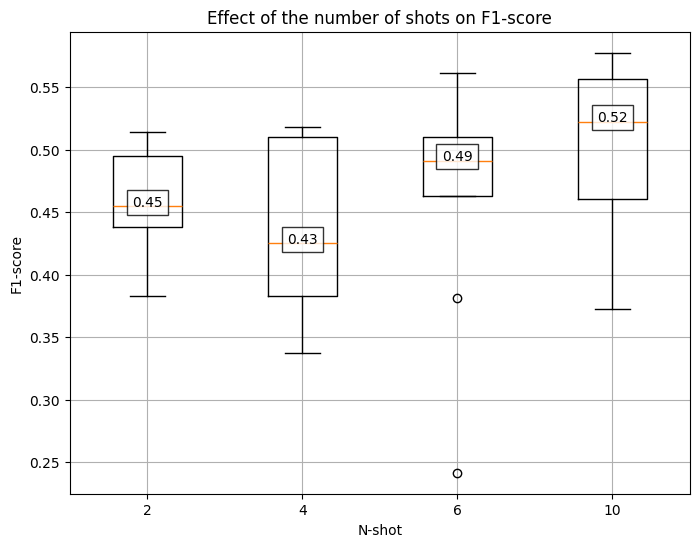

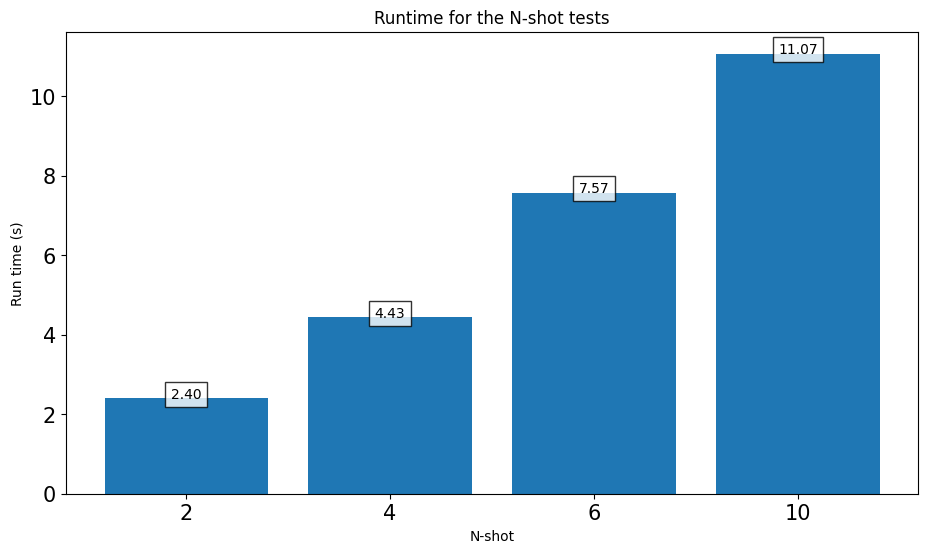

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values


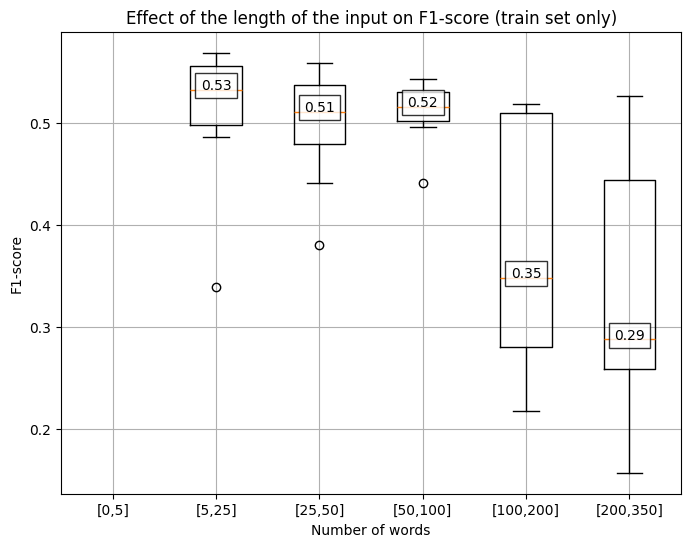

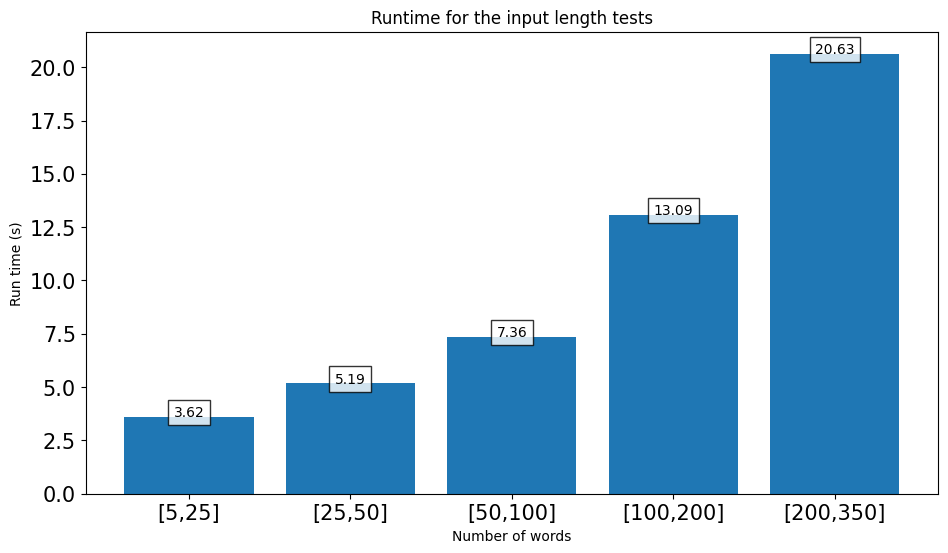

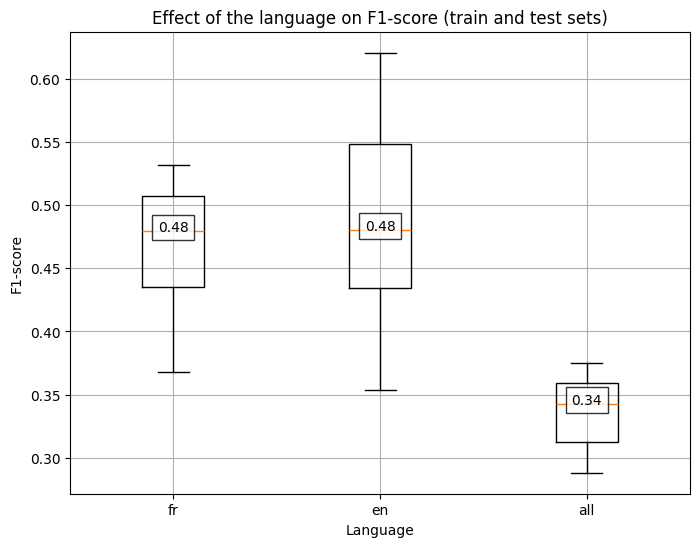

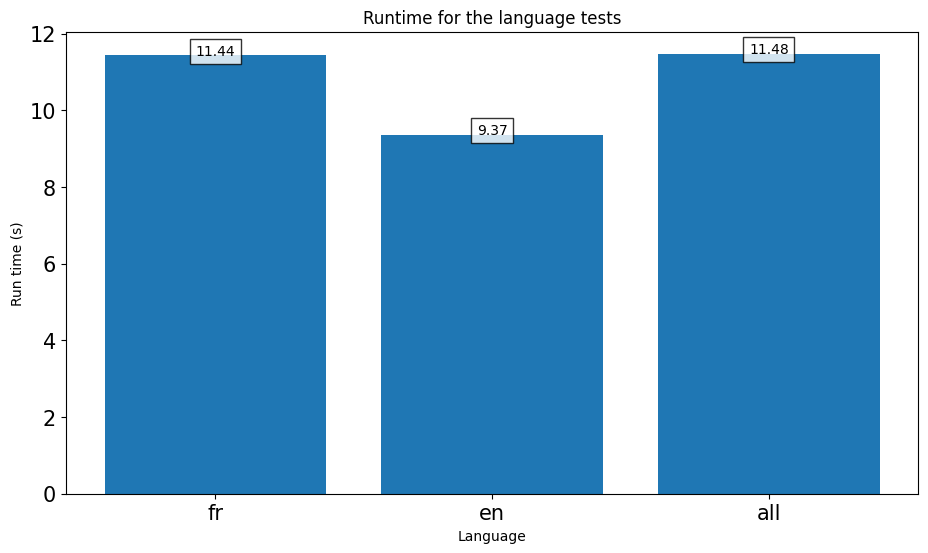

In [65]:
# results, run_times, _ = load_latest_results_data(r'../results/setfit/n_shot')
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# # create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/input_length')
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only) (8 shots)', 'Number of words', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the input length tests', 'Number of words', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/distance')
# create_boxplot(results, 'Effect of the distance on F1-score', 'Distance', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the distance tests', 'Distance', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/loss')
# create_boxplot(results, 'Effect of the loss on F1-score', 'Loss', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the loss tests', 'Loss', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/language')
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the language tests', 'Language', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/model')
# create_boxplot(results, 'Effect of the Sentence Transformer model on F1-score', 'Model', 'F1-score', vertical_xticks=True)
# create_bar_plot(run_times, 'Runtime for the Sentence Transformer model tests', 'Model', 'Run time (s)', vertical_xticks=True)

# results, run_times, _ = load_latest_results_data(r'../results/setfit/num_epochs')
# create_boxplot(results, 'Effect of the number of epochs on F1-score', 'Number of epochs', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the number of epochs tests', 'Number of epochs', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/head_learning_rate')
# create_boxplot(results, 'Effect of the head learning rate on F1-score', 'Head learning rate', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the head learning rate tests', 'Head learning rate', 'Run time (s)')

# results, run_times, params = load_latest_results_data(r'../results/setfit/data_sampling')
# create_boxplot(results, f"F1-score with the same params with {params['n_iter']} different support sets", str(params), 'F1-score')
# create_bar_plot(run_times, 'Runtime for the same params', str(params), 'Run time (s)')

# results, run_times, params = load_latest_results_data(r'../results/setfit/data_augmentation')
# create_boxplot(results, "Effect of data augmentation on F1-score", "Data augmentation strategy", 'F1-score', vertical_xticks=True)

# results, run_times, params = load_latest_results_data(r'../results/protonet/n_shot')
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/protonet/input_length')
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the input length tests', 'Number of words', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/protonet/language')
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the language tests', 'Language', 'Run time (s)')

### Plot graphs using all data and filters

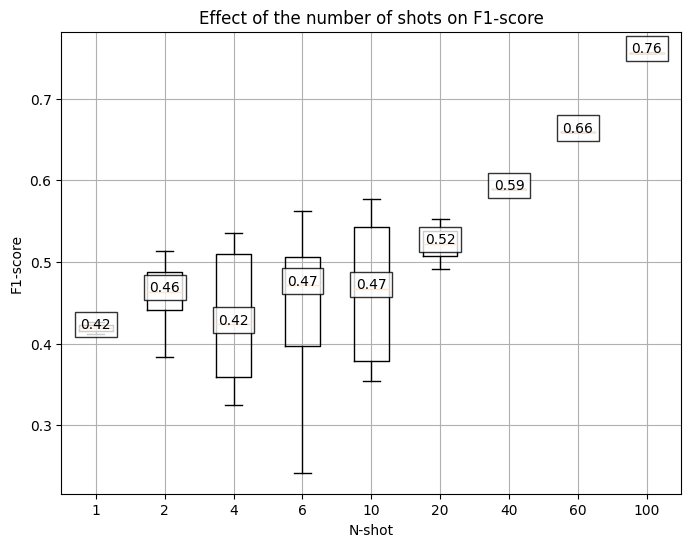

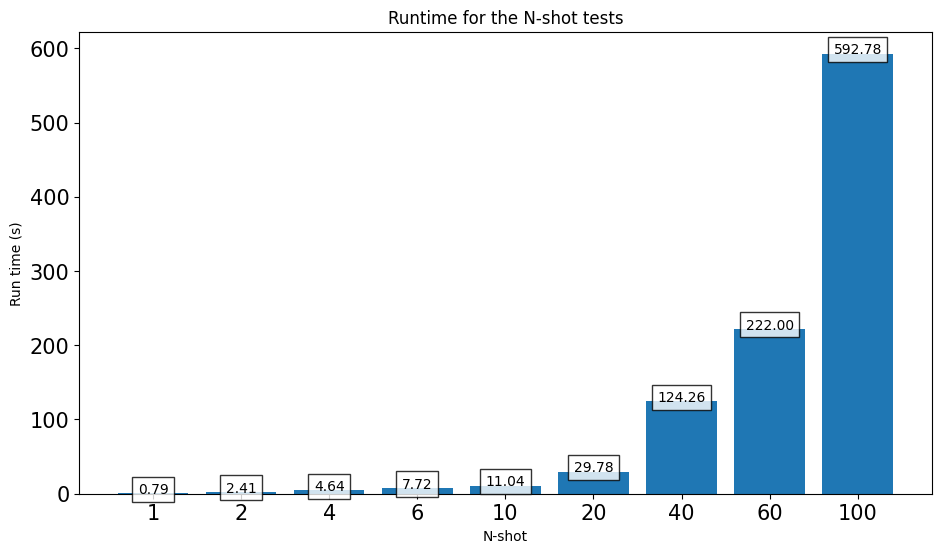

In [69]:
# results, run_times = load_all_results_data(r'../results/setfit/n_shot', "n_shot")
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times = load_all_results_data(r'../results/setfit/input_length', "input_length_range", {"input_length_range":[[0,5],[5,25],[25,50],[50,100],[100,200],[200,350]]})
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times = load_all_results_data(r'../results/setfit/language', "lang", {"model":"sentence-transformers/paraphrase-multilingual-mpnet-base-v2", "n_shot":8})
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets) (multilingual model) (8 shots)', 'Language', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/language', "lang", {"model":"sentence-transformers/paraphrase-mpnet-base-v2", "n_shot":8})
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets) (not multilingual model) (8 shots)', 'Language', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/model', "model", {"n_shot":8})
# create_boxplot(results, 'Effect of the model on F1-score (8 shots)', 'Model', 'F1-score', vertical_xticks=True)

# results, run_times = load_all_results_data(r'../results/setfit/num_epochs', "num_epochs", {"n_shot":8, "num_epochs":[(1,1),(2,1),(4,1),(8,1),(16,1),(32,1),(64,1)]})
# create_boxplot(results, 'Effect of the number of epochs (body) on F1-score (8 shots)', 'Number of epochs', 'F1-score', custom_xticks=['1','2','4','8','16','32','64'])
# create_bar_plot(run_times, 'Runtime for the body epochs tests', 'Number of epochs', 'Run time (s)', custom_xticks=['1','2','4','8','16','32','64'])

# results, run_times = load_all_results_data(r'../results/setfit/data_augmentation', "data_augmentation_strategy", {"data_augmentation_strategy":["none", "back_translation","crossover","swapping_inter","synonym_replacement"]})
# create_boxplot(results, f"Effect of the data augmentation ratio on F1-score (8 shots)", 'Strategy', 'F1-score', vertical_xticks=True)
# create_bar_plot(results, f"Runtime for the data augmentation tests", 'Strategy', 'Run time (s)', vertical_xticks=True)

# results, run_times = load_all_results_data(r'../results/setfit/training_set_labels_restriction', "model")
# create_boxplot(results, 'Effect of the training set labels restriction on F1-score', 'Model', 'F1-score', vertical_xticks=True)

results, run_times = load_all_results_data(r'../results/protonet/n_shot', "n_shot")
create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')